In [870]:
import numpy as np
import pandas as pd
import joblib
from keras import Sequential
from keras.layers import Dense, GRU, Dropout, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from matplotlib import pyplot as plt

In [872]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [873]:
def build_GRU_model(input_shape):
    model = Sequential(name="GRU")

    model.add(Input(shape=input_shape))
    model.add(GRU(units=128, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(GRU(units=64, return_sequences=True))

    model.add(GRU(units=32))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss="mean_squared_logarithmic_error")

    return model

In [874]:
df = pd.read_csv("../data/processed/mbajk_processed.csv")
df.head()

,available_bike_stands,surface_pressure,apparent_temperature,temperature,relative_humidity,date
0,7,8.692095e+130,8.153730,4.952523,760.081364,2023-06-25 19:00:00+00:00
1,8,8.692095e+130,7.893111,4.802400,956.923015,2023-06-25 20:00:00+00:00
2,4,8.731291e+130,7.555348,4.610693,1260.382417,2023-06-25 21:00:00+00:00
3,0,8.909824e+130,7.169603,4.457695,1652.740175,2023-06-25 22:00:00+00:00
4,0,9.010545e+130,6.882993,4.285642,2068.617364,2023-06-25 23:00:00+00:00


In [875]:
df.shape

(2344, 6)

In [876]:
target = "available_bike_stands"
features = [target] + [col for col in df.columns if col != target and col != "date"]

dataset = df[features]

In [877]:
dataset.shape

(2344, 5)

In [878]:
test_split = round(len(dataset) * 0.2)

train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [879]:
print(train_data.shape, test_data.shape)

(1875, 5) (469, 5)


In [880]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [881]:
window_size = 48

target_col_idx = df.columns.get_loc(target)

feature_cols_idx = [df.columns.get_loc(col) for col in features]

print(f"Target column index: {target_col_idx}")
print(f"Feature columns index: {feature_cols_idx}")

Target column index: 0
Feature columns index: [0, 1, 2, 3, 4]


In [882]:
X_train, y_train = create_multivariate_time_series(train_data, window_size, target_col_idx, feature_cols_idx)
X_test, y_test = create_multivariate_time_series(test_data, window_size, target_col_idx, feature_cols_idx)

print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (1827, 48, 5), y_train: (1827,)
Shape of testing data: X_test: (421, 48, 5), y_test: (421,)


In [883]:
input_shape = (X_train.shape[1], X_train.shape[2])

models = [build_GRU_model(input_shape)]

history = {}

In [884]:
for model in models:
    print(f"Training {model.name} model")
    fit_result = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test), verbose=1)
    history[model.name] = fit_result.history

Training GRU model
Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0839 - val_loss: 0.0153
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0060 - val_loss: 0.0089
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0054 - val_loss: 0.0092
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0059 - val_loss: 0.0087
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0057 - val_loss: 0.0094
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 9/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 10/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 11/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 12/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63

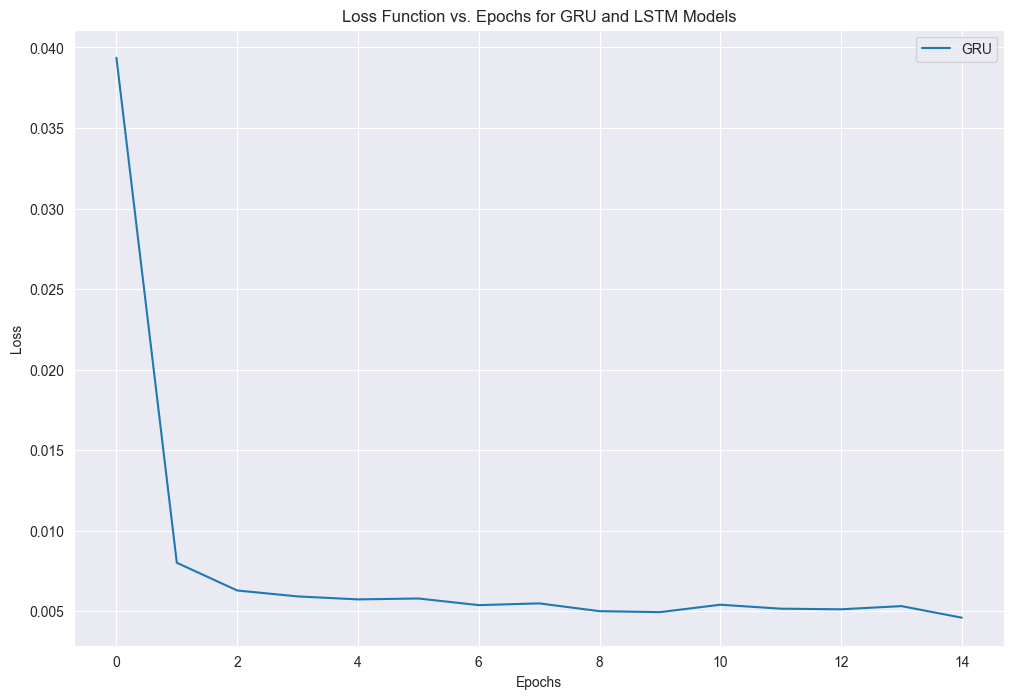

In [885]:
plt.figure(figsize=(12, 8))
for name, values in history.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for GRU and LSTM Models')
plt.legend()
plt.show()

In [886]:
y_test_copy = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy, (len(y_test), dataset.shape[1])))[:, 0]

In [887]:
dataset.shape[1]

5

In [888]:
results = {
    "MAE": [],
    "MSE": [],
    "EVS": []
}

for model in models:
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
GRU - MSE: 9.36
GRU - MAE: 2.20
GRU - EVS: 0.81
--------------------


In [889]:
prediction = models[0].predict(X_test)
prediction_copy_array = np.repeat(prediction, dataset.shape[1], axis=-1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [890]:
pred = scaler.inverse_transform(np.reshape(prediction_copy_array, (len(prediction), dataset.shape[1])))[:, 0]

In [891]:
dates = df['date'].values
df_output = pd.DataFrame({"date": dates[-test_split + window_size:], 'Actual': y_test, 'Predicted': pred})
df_output.head(20)

,date,Actual,Predicted
0,2023-09-16 03:00:00+00:00,16.0,15.510071
1,2023-09-16 04:00:00+00:00,16.0,15.647283
2,2023-09-16 05:00:00+00:00,18.0,15.787802
3,2023-09-16 06:00:00+00:00,21.0,17.463333
4,2023-09-16 07:00:00+00:00,21.0,18.962431
5,2023-09-16 08:00:00+00:00,20.0,19.139473
6,2023-09-16 09:00:00+00:00,21.0,18.823807
7,2023-09-16 10:00:00+00:00,21.0,18.931107
8,2023-09-16 11:00:00+00:00,17.0,18.655235
9,2023-09-16 12:00:00+00:00,19.0,15.641285


In [892]:
def plot_results(df):
    plt.figure(figsize=(12, 8))
    plt.plot(df['date'], df['Actual'], label="Actual")
    plt.plot(df['date'], df['Predicted'], label="Predicted")
    plt.xlabel('Date')
    plt.ylabel('Available Bike Stands')
    plt.title('Actual vs. Predicted Available Bike Stands')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


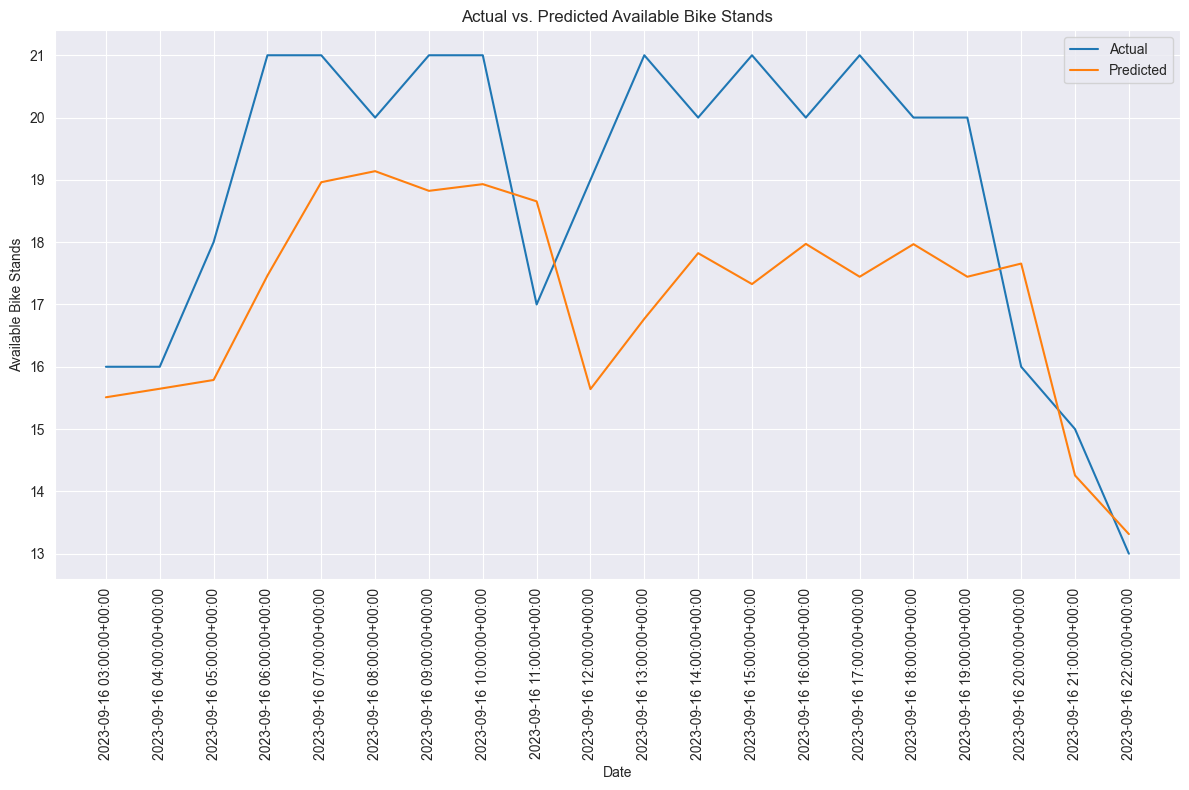

In [893]:
plot_results(df_output.head(20))

In [894]:
best_model = None
min_mse = float('inf')
for m in models:
    mse = results['MSE'][0][1]
    if mse < min_mse:
        min_mse = mse
        best_model = m

In [895]:
print("Best model:", best_model.name)
print("MSE:", min_mse)

Best model: GRU
MSE: 9.358481703851126


In [896]:
joblib.dump(scaler, "../models/minmax_scaler.gz")
best_model.save(f"../models/mbajk_{best_model.name}_mse_{format(min_mse, ".2f")}.keras")